In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import shap
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
results = {
    'SVM': [0.7747663551401869, 0.7747663551401869, 0.7747663551401869, 0.7747663551401869, 0.7747663551401869],
    'Decision Tree': [0.7850467289719626, 0.7850467289719626, 0.7850467289719626, 0.7845794392523364, 0.7850467289719626],
    'Random Forest': [0.8121495327102803, 0.8079439252336449, 0.8093457943925234, 0.8051401869158878, 0.8098130841121496],
    'XGBoost': [0.8168224299065421, 0.8168224299065421, 0.8168224299065421, 0.8168224299065421, 0.8168224299065421],
    'MLP': [0.803271, 0.792991, 0.796262, 0.797664, 0.797664]
}

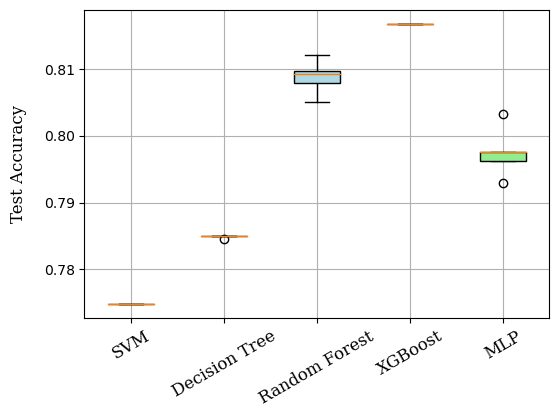

In [3]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))

bplot = axs.boxplot(results.values(), labels=['SVM', 'Decision\nTree', 'Random\nForest', 'XGBoost', 'MLP'], patch_artist=True)
colors = colors = ['pink', 'purple', 'lightblue', 'orange', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
fontdict = {'family':'serif', 'color':'black', 'weight':'normal', 'size':12}
axs.set_ylabel('Test Accuracy', fontdict=fontdict, labelpad=12)
axs.set_xticklabels(results.keys(), rotation=30, fontdict=fontdict)
axs.grid()
plt.show()

In [4]:
splits = ('train', 'val', 'test')
dfs = dict()
for split in splits:
    fn = f'./datasets/aaai-constraint-covid-appended/{split}.csv'
    df = pd.read_csv(fn, index_col=0).drop(['Segment',], axis=1)
    df.label = df.label.replace({'real': 1, 'fake': 0})
    dfs[split] = df

for split in splits:
    dfs[split] = dfs[split].drop(['tweet'], axis=1)
    dfs[split] = dfs[split].rename(columns={x: x.lower() for x in dfs[split].columns})
    columns = dfs[split].columns.tolist()
    dfs[split] = dfs[split][columns[1:]+[columns[0]]]

mean, std = dfs['train'].values[:, :-1].mean(), dfs['train'].values[:, :-1].std()
for split in splits:
    dfs[split].iloc[:, :-1] = (dfs[split].iloc[:, :-1] - mean) / (std + 1e-6)

In [5]:
def normalize(X_train, *X_other, eps=1e-6):

    mean, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
    yield (X_train-mean) / (std+eps)
    
    for X in X_other:
        yield (X-mean) / (std+eps)

X_train, y_train = dfs['train'].iloc[:, :-1].values, dfs['train'].iloc[:, -1].values
X_val, y_val = dfs['val'].iloc[:, :-1].values, dfs['val'].iloc[:, -1].values
X_test, y_test = dfs['test'].iloc[:, :-1].values, dfs['test'].iloc[:, -1].values

X_train, X_val, X_test = normalize(X_train, X_val, X_test)

In [6]:
xgb = XGBClassifier(booster='gbtree')
xgb.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

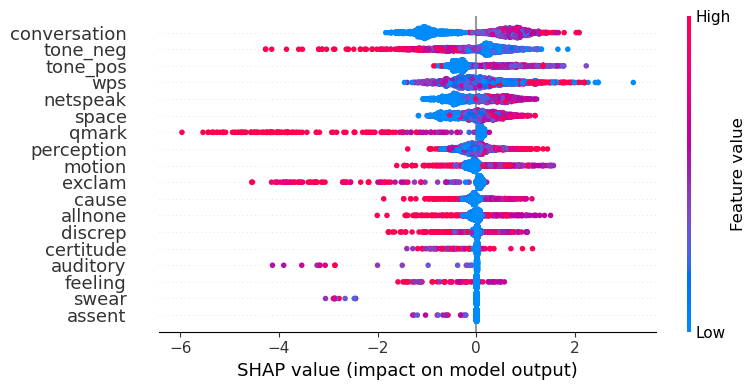

In [7]:
shap.summary_plot(shap_values, X_test, feature_names=columns[1:], sort=True, plot_type='dot', plot_size=(8,4))

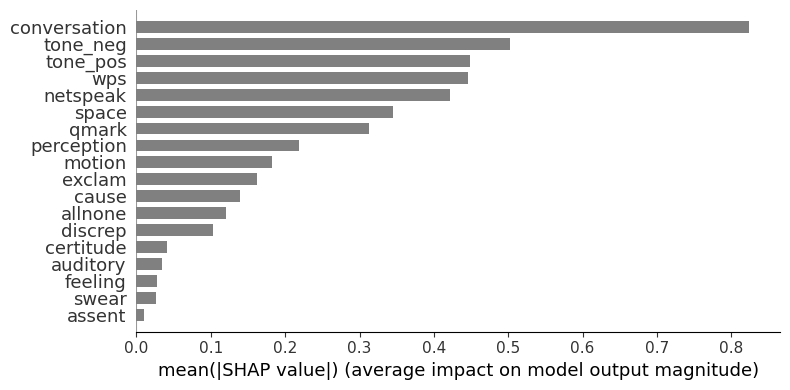

In [8]:
shap.summary_plot(shap_values, X_test, feature_names=columns[1:], sort=True, plot_type='bar', color='gray', plot_size=(8,4))

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


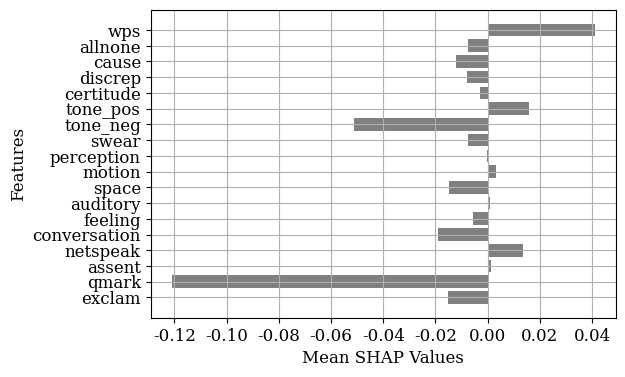

In [9]:
mean_shap = shap_values.mean(axis=0)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
fontdict = {'family':'serif', 'color':'black', 'weight':'normal', 'size':12}

plt.barh(columns[1:][::-1], mean_shap[::-1], color='gray')
plt.xlabel('Mean SHAP Values', fontdict=fontdict)
plt.ylabel('Features', fontdict=fontdict)
axs.set_xticklabels([f'{t:.2f}' for t in axs.get_xticks()], fontdict=fontdict)
axs.set_yticklabels(columns[1:][::-1], fontdict=fontdict)
plt.grid()